<a href="https://colab.research.google.com/github/anubhavgupta1/Dive-Into-Deep-Learning/blob/main/Projects/Style%20Transfer/mxnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l==0.16.1
!pip install -U mxnet-cu101==1.7.0

In [2]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn

npx.set_np()

###  Reading the Content and Style Images

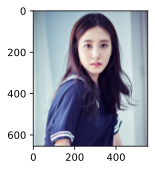

In [3]:
d2l.set_figsize()
content_img = image.imread('park.jpg')
d2l.plt.imshow(content_img.asnumpy());

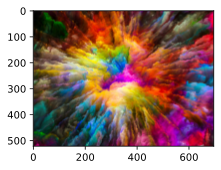

In [4]:
style_img = image.imread('style.jpg')
d2l.plt.imshow(style_img.asnumpy());

### Preprocessing and Postprocessing

In [5]:
rgb_mean = np.array([0.485, 0.456, 0.406])
rgb_std = np.array([0.229, 0.224, 0.225])

In [6]:
def preprocess(img, image_shape):
    
    print("shape of image is : ", image_shape)
    print("Number of incoming channels : ", len(image_shape)) 
    
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    
    print("shape of image is : ", img.shape)
    
    img = np.expand_dims(img.transpose(2, 0, 1), axis=0)
    
    print("shape of image is : ", img.shape,"\n\n\n")
    
    return img

In [7]:
x = preprocess(content_img, content_img.shape)

shape of image is :  (655, 554, 3)
Number of incoming channels :  3
shape of image is :  (554, 655, 3)
shape of image is :  (1, 3, 554, 655) 





In [8]:
def postprocess(img):
    
    print("shape of image is : ", img.shape)
    
    img = img[0].as_in_ctx(rgb_std.ctx)

    img = img.transpose(1, 2, 0) * rgb_std + rgb_mean
    
    print("shape of image is : ", img.shape)
    
    img = img.clip(0, 1)
    
    print("shape of image is : ", img.shape,"\n\n\n")
    
    return img

### Pretrained VGG

In [9]:
pretrained_net = gluon.model_zoo.vision.vgg19(pretrained=True)

In [10]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [11]:
(content_layers + style_layers)

[25, 0, 5, 10, 19, 28]

In [12]:
range(max(content_layers + style_layers) + 1)

range(0, 29)

### Model

In [13]:
net = nn.Sequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretrained_net.features[i])

### Extracting Features

In [14]:
def extract_features(X, content_layers, style_layers):
    print("\nInitial Shape : ",X.shape )
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            print("Style Layer : ", i, " shape : ", X.shape)
            styles.append(X)
        if i in content_layers:
            print("Content Layer : ", i, " shape : ", X.shape)
            contents.append(X)
    print("\n")
    return contents, styles

In [15]:
def get_contents(image_shape, device):
    print("\nGetting Content : ")
    content_X = preprocess(content_img, image_shape).copyto(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

In [16]:
def get_styles(image_shape, device):
    print("\nGetting Style : ")
    style_X = preprocess(style_img, image_shape).copyto(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

### Defining the Loss Function

#### Content Loss

In [17]:
def content_loss(Y_hat, Y):
    return np.square(Y_hat - Y).mean()

#### Style Loss

In [18]:
def gram(X):
    
    print("\nGetting Gram matrix : ")
    num_channels, n = X.shape[1], X.size // X.shape[1]
    
    
    print("Shape is : ", X.shape)
    print("Channels : ",num_channels)
    print("N : ",n)

    X = X.reshape((num_channels, n))
    
    
    print("Shape is : ", X.shape)
    
    X = np.dot(X, X.T) / (num_channels * n)
    
    print("Shape is : ", X.shape,"\n\n\n")

    return X

In [19]:
def style_loss(Y_hat, gram_Y):
    y_hat = gram(Y_hat)
    y = gram_Y
    return np.square(y_hat - y).mean()

####  Total Variance Loss

In [20]:
def tv_loss(Y_hat):
    temp1 = np.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean()
    temp2 = np.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean()
    return 0.5 * (temp1 + temp2)

#### Loss Function

In [21]:
content_weight, style_weight, tv_weight = 0.5, 1e3, 10

In [22]:
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # Calculate the content, style, and total variance losses respectively
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # Add up all the losses
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

### Creating and Initializing the Composite Image

In [23]:
class GeneratedImage(nn.Block):
    def __init__(self, img_shape, **kwargs):
        super(GeneratedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)

    def forward(self):
        return self.weight.data()

In [24]:
def get_inits(X, device, lr, styles_Y):
    gen_img = GeneratedImage(X.shape)
    gen_img.initialize(init.Constant(X), ctx=device, force_reinit=True)
    trainer = gluon.Trainer(gen_img.collect_params(), 'adam',{'learning_rate': lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [25]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',xlim=[10, num_epochs],legend=['content', 'style', 'TV'], ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        print("Epoch = ", epoch+1,"/",num_epochs)
        with autograd.record():
            contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)
            contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step(1)
        npx.waitall()
        if (epoch + 1) % lr_decay_epoch == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X).asnumpy())
            animator.add(epoch + 1, [float(sum(contents_l)),float(sum(styles_l)), float(tv_l)])
    return X

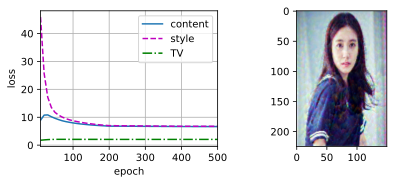

In [26]:
device, image_shape = d2l.try_gpu(), (150, 225)
net.collect_params().reset_ctx(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.01, 500, 200)

shape of image is :  (1, 3, 900, 600)
shape of image is :  (900, 600, 3)
shape of image is :  (900, 600, 3) 





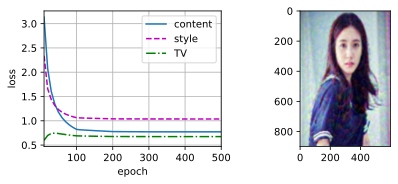

In [27]:
image_shape = (600, 900)
_, content_Y = get_contents(image_shape, device)
_, style_Y = get_styles(image_shape, device)
X = preprocess(postprocess(output) * 255, image_shape)
output = train(X, content_Y, style_Y, device, 0.01, 500, 100)
d2l.plt.imsave('neural-style.jpg', postprocess(output).asnumpy())

shape of image is :  (1, 3, 1350, 900)
shape of image is :  (1350, 900, 3)
shape of image is :  (1350, 900, 3) 





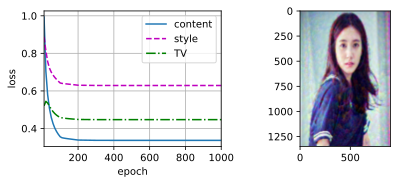

In [28]:
image_shape = (900, 1350)
_, content_Y = get_contents(image_shape, device)
_, style_Y = get_styles(image_shape, device)
X = preprocess(postprocess(output) * 255, image_shape)
output = train(X, content_Y, style_Y, device, 0.01, 1000, 100)
d2l.plt.imsave('neural-style.jpg', postprocess(output).asnumpy())